# Overview

Ensemble combined with LDA is effective in predicting age based on gene expression data. However, this method is prone to batch problem. The batch problem may caused by the different techniques in breeding cells that lead to difference in the mean gene expression level of cells between batches. 

kTSP is a potential solution to the batch problem because it uses the relative gene expression level rather than the raw qualititative data. It also involves significant less amount of features, improving both the speed of training and predicting and the interpretability of the features.

The data used for training in this notebook are all from gene_labelled_data.csv

# KTSP classifier and feature selection

This notebook completes three tasks: 10-fold CV repetead 3 times for predicting age using kTSP classifer on entire data; feature selection of gene pairs by kTSP algorithm to use in ensemble; and predict age on data reserved from feature selection using kTSP classifier.

# Set-up
rpy2 version: 3.4.5
\
R version: 4.1.0
\
multiClassPairs version: 0.4.3
\
switchBox version: 1.28.0
\
python version: 3.8.8
\
scikit-learn version: 0.24.1
\
seaborn version:  0.11.1 

In [13]:
%run age_predictors.py

In [9]:
#Importing interfaces and packages
#Activate pandas2ri, numpy2ri for automatic transformation of python data structure to R

import pandas as pd
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from sklearn.model_selection import train_test_split
pandas2ri.activate()
from rpy2.robjects import r
from sklearn.utils import shuffle
import rpy2.robjects.numpy2ri
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
rpy2.robjects.numpy2ri.activate()

In [2]:
print(rpy2.situation.get_r_home())

/Library/Frameworks/R.framework/Resources


In [3]:
print(rpy2.__version__)

3.4.5


In [4]:
#Import R biocManager packages
base = importr('base')
switchBox = importr('switchBox')
multiclass = importr('multiclassPairs')

In [10]:
#This method loads the data
#Set uid, age, meta as indices
def load_data(filename, transpose=False):
    
    ending = filename.split('.')[-1]
    
    if ending == 'csv':
        data = pd.read_csv(filename,header=None,index_col=None)
    elif ending == 'xlsx':
        data = pd.read_xlsx(filename,header=None,index_col=None)
    else:
        raise TypeError('dont know what file type this is')
    
    if transpose:
        data = data.T
    
    # make sure the index columns are named correctly, 
    # otherwise use whatever the first row (header) contains for gene/transcript names
    cols = data.iloc[0,:]
    cols[0] = 'uid'
    cols[1] = 'age'
    cols[2] = 'meta'
    data.columns = cols
    
    # get the data, not the header now that we formed it
    data = data.iloc[1:,:]
    
    # make sure the age comes in as integer years... if you need to do floating point change this
    data.iloc[:,1] = data.iloc[:,1].astype(int)
    
    data = data.set_index(['uid','age','meta']).astype(float)
    
    return data


In [11]:
data = load_data('gene_labelled_data.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251

In [14]:
crossval = RepeatedKFold(n_repeats=3, n_splits=10)
#r_train_data = robjects.conversion.py2rpy(train_data.transpose())

In [15]:
#TODO: Modify to get lables later
def get_labels(data_for_labels):
    labels_age = data_for_labels.index.get_level_values('age').values
    #print(len(data_for_labels))
    #display(train_labels_age)

    labels = []
    #ages = labels_age[train]
    for age in labels_age:
        if age>=1 and age<20:
            labels.append('age_1_20')
        elif age>=20 and age<40:
            labels.append('age_20_40')
        elif age>=40 and age<60:
            labels.append('age_40_60')
        elif age>=60 and age<80:
            labels.append('age_60_80')
        elif age>=80 and age<100:
            labels.append('age_80_100')

    #display(train_labels)
    labels = np.array(labels)
    print(len(labels))
    return labels

    #r_train_labels = robjects.conversion.py2rpy(train_labels)

In [16]:
def get_age(results):
    pred = []
    for result in results:
        pred.append(result[5])
        
    return pred

In [17]:
#From stackoverflow
def plot_confusion_matrix(true, pred):
    #Convert to a method
    cm = confusion_matrix(true, pred)
    labels = ['age_1_20', 'age_20_40', 'age_40_60', 'age_60_80', 'age_80_100']

    fig = plt.figure(figsize=(8, 7))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); 
    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(labels, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    ax.yaxis.set_ticklabels(labels, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    plt.savefig('ConMat24.png')
    plt.show()

# Part I: kTSP classifier on entire data
This segment of code implements an entire kTSP classifier. It trains and predicts on the entire dataset by 10-fold CV repeated 3 times. It generates a graph that demonstrate the confusion matrix of the predicted and true classes. 

Notice that kTSP is a classification algorithm, so quantative predictions of age is not generated. The sample ages are divided into 5 classes: 0-20, 20-40, 40-60, 60-80, and 80-100 year old. The predictions fall into the 5 classes listed. 

In [19]:
#Initialize empty data structure to store predicted and true age classes
true_age = []
pred_age = []

#10-fold CV repeated 3 times
for train, test in crossval.split(data):
    
    #Get the labels for training
    train_labels = get_labels(data.iloc[train,:])
    #Save true age classes
    true_age.append(get_labels(data.iloc[test,:]))
    #Get test data
    test_data = data.iloc[test,:]
    
    #Create object for training kTSP classifier
    object = r['ReadData']((data.iloc[train,:]).transpose(), train_labels)
    
    #Filter genes and train kTSP classifier to get representative gene pairs
    filtered_genes = r['filter_genes_TSP'](data_object = object, filter = "one_vs_rest", 
                                           platform_wise = False, featureNo = 1000, UpDown = True)
    
    classifier = r['train_one_vs_rest_TSP'](data_object = object, filtered_genes = filtered_genes,
                                        include_pivot = False,one_vs_one_scores = False, 
                                        platform_wise_scores = False,seed = 1234, verbose = False)
    
    #Use one-vs-rest scheme to do multiclassification using kTSP
    raw_results_test = r['predict_one_vs_rest_TSP'](classifier = classifier, Data = test_data.transpose(), 
                                            tolerate_missed_genes = False, weighted_votes = True)
    
    #Unravel R data structue to get the prediction of age class
    results_test = get_age(raw_results_test)
    pred_age.append(results_test)


119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

119
14


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 119

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

120
13


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 120

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_1_20 age_20_40 age_40_60 age_60_80 age_80_100

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_1_20

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: DONE!

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_40_60

R[write to cons

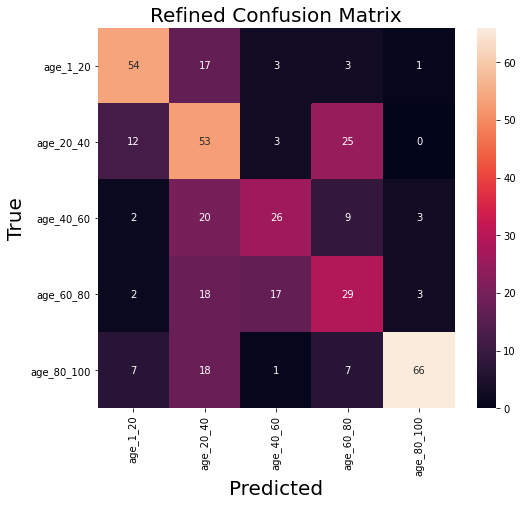

In [20]:
#Plot the confusion matrix
pred = flatten(pred_age)
true = flatten(true_age)
plot_confusion_matrix(true, pred)

# Part II: Feature selection using kTSP algorithm
This segment of code completes feature selection for the ensemble using the filter method. 33 samples are chosen randomly from the entire sample. kTSP algorithm is performed on the 33 sample to select representative gene expression pairs. 

A new csv file is generated based on the features selected. Each pair is a column of the csv file in the form "geneA>geneB". For each person in the reserved 100 samples, if the expression of geneA is greater than geneB, 1 is put in the "geneA>geneB" column. Otherwise, 0 is put in the "geneA>geneB" column. Following this rule, a binary expression matrix is generated. 

The csv file containing the binary expression matrix will be put into the ensemble. (However, the binary expression matrix does not work well with LDA ensemble. Possible reason is that the binary expression matrix does not keep the Gaussian distribution of the data. Another possible reason is that too few samples used in feature selection, so gene pairs that are not representative of age are chosen.)

In [27]:
#Prepare data for filter method
data = shuffle(data)

#Get train data and feature selection set
train = range(33,133)
FS = range(0,33)
FS_labels = get_labels(data.iloc[FS,:])
#FS_age = (get_labels(data.iloc[FS,:]))
FS_data = data.iloc[FS,:]

#Get reserved data
U_data = data.iloc[train, :]
display(FS_data)

33


,,,MPV17L,AFF4,ZGLP1,LOC105373021,GABPB1-AS1,CHDH,C12orf74,MIR6801,ZFP90,KDM6B,...,MIR30B,TCEAL2,PNPLA5,LINC01055,RUFY3,FGFRL1,GALNT8,CCNG2,LOC646762,SLC25A48
uid,age,meta,,,,,,,,,,,,,,,,,,,,,
17,25,normal,0.048,18.782,0.217,0.0,0.921,0.073,0.0,34.368,4.003,1.790,...,0.0,0.000,0.000,0.0,7.000,42.926,0.000,3.297,0.491,0.0
165,68,normal,0.235,13.411,0.798,0.0,0.601,0.116,0.0,28.753,5.942,1.714,...,0.0,0.000,0.000,0.0,4.688,22.356,0.000,5.458,0.949,0.0
110,32,normal,0.025,16.427,0.626,0.0,1.101,0.365,0.0,27.374,4.923,1.236,...,0.0,0.000,0.026,0.0,5.120,35.829,0.000,7.743,0.661,0.0
62,84,normal,0.120,16.594,0.645,0.0,0.924,0.961,0.0,30.923,5.885,1.234,...,0.0,0.000,0.000,0.0,4.758,35.327,0.000,5.616,1.541,0.0
123,57,normal,0.104,20.292,0.412,0.0,0.943,0.378,0.0,26.085,4.717,1.384,...,0.0,0.106,0.000,0.0,5.889,28.255,0.000,9.735,1.036,0.0
82,3,normal,0.000,14.743,0.292,0.0,0.991,0.109,0.0,23.662,4.891,1.640,...,0.0,0.000,0.000,0.0,6.077,40.241,0.000,6.544,1.277,0.0
38,43,normal,0.265,16.648,0.400,0.0,1.136,0.227,0.0,34.197,5.180,1.752,...,0.0,0.045,0.000,0.0,3.583,22.356,0.000,6.021,1.281,0.0
114,37,normal,0.022,18.592,0.177,0.0,1.211,0.217,0.0,27.585,5.723,2.023,...,0.0,0.137,0.000,0.0,4.139,11.340,0.024,5.953,1.203,0.0
25,30,normal,0.141,15.831,0.510,0.0,1.020,0.426,0.0,20.163,6.122,2.147,...,0.0,0.000,0.000,0.0,6.228,22.998,0.030,7.852,0.936,0.0


In [28]:
np.unique(U_data.dtypes, return_counts=True)

(array([dtype('float64')], dtype=object), array([27142]))

In [29]:
U_data.index.get_level_values('meta')

Index(['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal',

In [30]:
#Train the kTSP classifier
object = r['ReadData'](FS_data.transpose(), FS_labels)
filtered_genes = r['filter_genes_TSP'](data_object = object, filter = "one_vs_rest", platform_wise = False, featureNo = 1000, UpDown = True)
    
classifier = r['train_one_vs_rest_TSP'](data_object = object, filtered_genes = filtered_genes,
                                        include_pivot = False,one_vs_one_scores = False, 
                                        platform_wise_scores = False,seed = 1234, verbose = False)


R[write to console]: Creating Data object...

R[write to console]: Number of samples: 33

R[write to console]: Number of genes/features: 27142

R[write to console]: Classes: age_20_40 age_60_80 age_80_100 age_40_60 age_1_20

R[write to console]: Platforms/studies: NULL

R[write to console]: Gene names in the data have '-' symbol! This may generate errors during the training process of random forest! It is recommended to change these '-' to '_' or '.'

R[write to console]: Creating new filtered genes object for one-vs-rest Scheme

R[write to console]: filtering...

R[write to console]: Class:  age_20_40

R[write to console]: Class:  age_60_80

R[write to console]: Class:  age_80_100

R[write to console]: Class:  age_40_60

R[write to console]: Class:  age_1_20

R[write to console]: DONE!



In [31]:
#From Stackoverflow: 
#This method unravels the kTSP classifier that is stored as convoluted R vector.
def r_list_to_py_dict(r_list):
    converted = {}
    for name in r_list.names:
        val = r_list.rx(name)[0]
        if isinstance(val, robjects.vectors.DataFrame):
            converted[name] = pandas2ri.ri2py_dataframe(val)
        elif isinstance(val, robjects.vectors.ListVector):
            converted[name] = r_list_to_py_dict(val)
        elif isinstance(val, robjects.vectors.FloatVector) or isinstance(val, robjects.vectors.StrVector):
            if len(val) == 1:
                converted[name] = val[0]
            else:
                converted[name] = list(val)
        else: # single value
            converted[name] = val
    return converted

In [32]:
#R to python data structure
py_classifier = r_list_to_py_dict(classifier)
display(py_classifier) #TODO: Check on how the genes are paired

{'classifiers': {'age_20_40': {'name': '31TSPS',
   'TSPs': ['COL7A1',
    'LINC01337',
    'NPTX2',
    'FAAHP1',
    'MTFP1',
    'RNF24',
    'SNORA68',
    'MIR711',
    'SNORD30',
    'MIR6859-3',
    'DPY19L2',
    'DHRS4-AS1',
    'GDF9',
    'ICOSLG',
    'UCN2',
    'FBXO2',
    'MIR1229',
    'YWHAEP1',
    'SOCS3',
    'CCDC151',
    'SLC35D2',
    'SYCP2',
    'CRAT',
    'PCTP',
    'LOC100505841',
    'PPARGC1B',
    'MIR6813',
    'PRSS35',
    'ZNF257',
    'KANK4',
    'LAPTM5',
    'MRPS28',
    'LINC00211',
    'MIR103A2',
    'F11R',
    'FOXL1',
    'TK2',
    'HAND2-AS1',
    'ADARB1',
    'AKR1C3',
    'CCDC136',
    'TMEM220-AS1',
    'DOK5',
    'BRWD1-IT2',
    'CFAP43',
    'RNLS',
    'SLC2A9',
    'C1orf122',
    'MORN1',
    'ATG16L1',
    'LOC100129534',
    'SKP1P2',
    'CCT6B',
    'ATP6V1H',
    'WDR73',
    'GDF10',
    'GMNC',
    'OAZ3',
    'TMEM30B',
    'LINC01614',
    'C1QTNF3',
    'HIF1A-AS1'],
   'score': array([0.90931927, 0.86396604, 0.81

In [86]:
#Unravel python data structure to list
list_pairs = list(py_classifier.values())
display(list_pairs)

[{'age_1_20': {'name': '22TSPS',
   'TSPs': ['DSCAM',
    'KAZALD1',
    'KLHDC8B',
    'MINCR',
    'C6orf226',
    'UBTD1',
    'LOC90246',
    'TP73-AS1',
    'NOMO2',
    'PPOX',
    'SH2B1',
    'CTBP1-AS2',
    'EFNA4',
    'ARMCX6',
    'EMC8',
    'PRKRIP1',
    'HEIH',
    'PNKD',
    'BORCS6',
    'ZNF696',
    'G6PD',
    'LAMTOR4',
    'C1orf115',
    'EEA1',
    'SNORD47',
    'UBE2D1',
    'RAP2C',
    'SLC25A46',
    'CASD1',
    'SPRED1',
    'LYPLA1',
    'DPY19L3',
    'LIMS1',
    'FMR1',
    'RICTOR',
    'BCL10',
    'ABCE1',
    'RNF139',
    'TRIP11',
    'PPP1CB',
    'EXOC8',
    'RPL23AP53',
    'SRSF6',
    'YBX3'],
   'score': array([1.0005099 , 1.00040471, 1.00040048, 1.00031545, 1.00030044,
          1.00029503, 1.00029342, 1.00023447, 1.00022908, 1.00022264,
          1.00022226, 1.00021949, 1.00017198, 1.00016491, 1.00015716,
          1.00015207, 1.00015146, 1.00014913, 1.00013543, 1.00010705,
          1.00010298, 1.00006348]),
   'tieVote': array([1, 

In [87]:
#Unravel python list
type(list_pairs)
display(list_pairs[0])

{'age_1_20': {'name': '22TSPS',
  'TSPs': ['DSCAM',
   'KAZALD1',
   'KLHDC8B',
   'MINCR',
   'C6orf226',
   'UBTD1',
   'LOC90246',
   'TP73-AS1',
   'NOMO2',
   'PPOX',
   'SH2B1',
   'CTBP1-AS2',
   'EFNA4',
   'ARMCX6',
   'EMC8',
   'PRKRIP1',
   'HEIH',
   'PNKD',
   'BORCS6',
   'ZNF696',
   'G6PD',
   'LAMTOR4',
   'C1orf115',
   'EEA1',
   'SNORD47',
   'UBE2D1',
   'RAP2C',
   'SLC25A46',
   'CASD1',
   'SPRED1',
   'LYPLA1',
   'DPY19L3',
   'LIMS1',
   'FMR1',
   'RICTOR',
   'BCL10',
   'ABCE1',
   'RNF139',
   'TRIP11',
   'PPP1CB',
   'EXOC8',
   'RPL23AP53',
   'SRSF6',
   'YBX3'],
  'score': array([1.0005099 , 1.00040471, 1.00040048, 1.00031545, 1.00030044,
         1.00029503, 1.00029342, 1.00023447, 1.00022908, 1.00022264,
         1.00022226, 1.00021949, 1.00017198, 1.00016491, 1.00015716,
         1.00015207, 1.00015146, 1.00014913, 1.00013543, 1.00010705,
         1.00010298, 1.00006348]),
  'tieVote': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [88]:
#Unravel and cast python list to panda dataFrame
df = pd.DataFrame(list_pairs[0])
display(df.columns)

Index(['age_1_20', 'age_60_80', 'age_40_60', 'age_20_40', 'age_80_100'], dtype='object')

In [89]:
#Unravel panda dataFrame
display(df['age_20_40'].TSPs)

['SULT4A1',
 'GRIK1-AS2',
 'MIR6812',
 'MRI1',
 'PRPF39',
 'TMBIM4',
 'PRR7-AS1',
 'MRS2P2',
 'MIR6834',
 'SNORA27',
 'DNAJC25-GNG10',
 'C2orf66',
 'SNORA44',
 'LINC00961',
 'BBIP1',
 'LINC01311',
 'TMEM92',
 'CBWD2',
 'MICU2',
 'LINC00115',
 'TXNL1',
 'ALOX5AP',
 'KCNA4',
 'CNBD2',
 'SNORA20',
 'TSACC',
 'SOX9',
 'ETFRF1',
 'SPON1',
 'GDF9',
 'CBWD1',
 'LOC728024',
 'AFF2',
 'KLHL5',
 'URB1-AS1',
 'TATDN1',
 'MTERF4',
 'HSH2D',
 'KRT17',
 'GDE1',
 'SLC11A2',
 'HMGCR',
 'ATP6V1B2',
 'IDH1-AS1',
 'POMC',
 'CAMK2G',
 'IKBKG',
 'NAAA',
 'LOC100130111',
 'TMEM106A',
 'PDZD7',
 'KBTBD4',
 'ZRANB3',
 'CATSPER2P1',
 'LRCH1',
 'NSF',
 'LOC100133091',
 'MLEC',
 'LOC100506804',
 'LINC01336',
 'TBX4',
 'MAP3K5',
 'ATE1-AS1',
 'MIR6513',
 'SKP2',
 'OSTCP1',
 'OSGEPL1-AS1',
 'MAGI1',
 'HOXD-AS2',
 'AXIN2',
 'TMEM44',
 'SNORD32A',
 'ADCY3',
 'MIR221']

In [33]:
#This method unravels the kTSP classifier and gets all the representative gene pairs
#Notice that still need to read the source code of switchBox and multiclassPairs to
#ensure that the pairs are parsed in the correct way

#Each gene pair is stored in a tuple
#All the tuples are stored in a list
def get_pairs (classifier):
    
    #Unravel the R classifier into a python data structure
    py_classifier = r_list_to_py_dict(classifier)
    list_pairs = list(py_classifier.values())
    df = pd.DataFrame(list_pairs[0])

    pairs = []
    for age_class in df.columns:
        kTSP = df[age_class].TSPs
        
        i = 0
        while (i < len(kTSP)):
            pair = (kTSP[i], kTSP[i+1])
            pairs.append(pair)
            
            i += 2
    
    #Remove possible duplicates and cast back to list
    pairs = list(set(pairs))        
    return pairs

In [34]:
#Get the gene pairs
pairs = get_pairs(classifier)
display(pairs)
display(len(pairs))

[('KCNA4', 'PEG3'),
 ('CAV2', 'SGMS1'),
 ('LINC01819', 'LOC100506178'),
 ('CADM1', 'CIT'),
 ('C1QTNF3', 'HIF1A-AS1'),
 ('PLPP7', 'LOC101927932'),
 ('LOC100129534', 'SKP1P2'),
 ('HTR1F', 'B4GALNT1'),
 ('MORN1', 'ATG16L1'),
 ('RGAG4', 'GJD3'),
 ('FILIP1', 'MIR4749'),
 ('C19orf33', 'SFRP4'),
 ('LOC100289361', 'MYH15'),
 ('F11R', 'FOXL1'),
 ('COPS9', 'CYP2D7'),
 ('CRAT', 'PCTP'),
 ('SRGN', 'MGAM'),
 ('TMED1', 'PXMP2'),
 ('MTFP1', 'RNF24'),
 ('GDF9', 'ICOSLG'),
 ('KRT4', 'PDE1C'),
 ('CCDC136', 'TMEM220-AS1'),
 ('TBC1D5', 'TANC2'),
 ('ALMS1-IT1', 'FAM218A'),
 ('PGRMC2', 'TSPYL1'),
 ('ZYG11A', 'CCNA2'),
 ('BMP6', 'ACP2'),
 ('WDR73', 'GDF10'),
 ('SOCS5', 'BROX'),
 ('RGL1', 'TRAK1'),
 ('MIR155HG', 'SSX2IP'),
 ('CD9', 'NTM'),
 ('CCT6B', 'ATP6V1H'),
 ('YWHAEP1', 'MKKS'),
 ('TWIST1', 'GLI1'),
 ('TK2', 'HAND2-AS1'),
 ('SAA2', 'GPRC5A'),
 ('ITGAE', 'DHPS'),
 ('ZNF681', 'BCL6B'),
 ('BACH1', 'MTCL1'),
 ('ZNF257', 'KANK4'),
 ('ALPK2', 'RRAS2'),
 ('TMEM192', 'TP53INP1'),
 ('CFAP43', 'RNLS'),
 ('NCF4', '

156

In [35]:
#This method gets the names of the gene pairs
def get_pairs_name(pairs):
    names = []
    
    for pair in pairs:
        name = ">".join([str(pair[0]), str(pair[1])])
        names.append(name)
        
    return names

In [36]:
#Get names of all the pairs
pair_names = get_pairs_name(pairs)
display(pair_names)

['KCNA4>PEG3',
 'CAV2>SGMS1',
 'LINC01819>LOC100506178',
 'CADM1>CIT',
 'C1QTNF3>HIF1A-AS1',
 'PLPP7>LOC101927932',
 'LOC100129534>SKP1P2',
 'HTR1F>B4GALNT1',
 'MORN1>ATG16L1',
 'RGAG4>GJD3',
 'FILIP1>MIR4749',
 'C19orf33>SFRP4',
 'LOC100289361>MYH15',
 'F11R>FOXL1',
 'COPS9>CYP2D7',
 'CRAT>PCTP',
 'SRGN>MGAM',
 'TMED1>PXMP2',
 'MTFP1>RNF24',
 'GDF9>ICOSLG',
 'KRT4>PDE1C',
 'CCDC136>TMEM220-AS1',
 'TBC1D5>TANC2',
 'ALMS1-IT1>FAM218A',
 'PGRMC2>TSPYL1',
 'ZYG11A>CCNA2',
 'BMP6>ACP2',
 'WDR73>GDF10',
 'SOCS5>BROX',
 'RGL1>TRAK1',
 'MIR155HG>SSX2IP',
 'CD9>NTM',
 'CCT6B>ATP6V1H',
 'YWHAEP1>MKKS',
 'TWIST1>GLI1',
 'TK2>HAND2-AS1',
 'SAA2>GPRC5A',
 'ITGAE>DHPS',
 'ZNF681>BCL6B',
 'BACH1>MTCL1',
 'ZNF257>KANK4',
 'ALPK2>RRAS2',
 'TMEM192>TP53INP1',
 'CFAP43>RNLS',
 'NCF4>MISP',
 'KIAA1456>CPNE2',
 'MIR7847>MIR6775',
 'KIAA0408>TCTE3',
 'CENPJ>FANCM',
 'SAA1>MIR622',
 'OSBPL1A>MAML2',
 'PTPRG>PRR16',
 'BBX>MYLK',
 'VPS4B>AK5',
 'SLC2A9>C1orf122',
 'TNFAIP8L1>GNG2',
 'ZSCAN21>TTC13',
 'FANCE>A

In [37]:
#Generate a dummy data frame that contains 0 for all entries
#The columns are the names of each gene pair
dummy_binary = [0] * len(U_data)
df_bi = {}

for pair in pair_names:
    df_bi[pair] = dummy_binary

binary_xdata = pd.DataFrame(df_bi) 
display(binary_xdata)

,KCNA4>PEG3,CAV2>SGMS1,LINC01819>LOC100506178,CADM1>CIT,C1QTNF3>HIF1A-AS1,PLPP7>LOC101927932,LOC100129534>SKP1P2,HTR1F>B4GALNT1,MORN1>ATG16L1,RGAG4>GJD3,...,RPTN>DOCK10,MCMDC2>GPR85,LAPTM5>MRPS28,MTO1>FAM49B,MIR1229>YWHAEP1,SH3RF2>ISL2,TBKBP1>C9orf85,PSMC3IP>CDKN2D,EID2B>CDKAL1,OLFML3>BMF
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
#For each person compare the expression level of the genes in each gene pair
#If geneA>geneB of a person as specified in the column, 1 is put into the according entry

#Iterate through each person
for i in range(0, len(U_data)):
    
    #Iterate through each pair for each person
    for j in range(0, len(pairs)):
        #Get gene1 and gene2
        gene1 = pairs[j][0]
        gene2 = pairs[j][1]
        
        #Compare expression level of gene1 and gene2
        if U_data.iloc[i][gene1] > U_data.iloc[i][gene2]:
            binary_xdata.at[i, pair_names[j]] = 1
display(binary_xdata)

,KCNA4>PEG3,CAV2>SGMS1,LINC01819>LOC100506178,CADM1>CIT,C1QTNF3>HIF1A-AS1,PLPP7>LOC101927932,LOC100129534>SKP1P2,HTR1F>B4GALNT1,MORN1>ATG16L1,RGAG4>GJD3,...,RPTN>DOCK10,MCMDC2>GPR85,LAPTM5>MRPS28,MTO1>FAM49B,MIR1229>YWHAEP1,SH3RF2>ISL2,TBKBP1>C9orf85,PSMC3IP>CDKN2D,EID2B>CDKAL1,OLFML3>BMF
0,1,1,0,0,1,1,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
1,0,1,0,1,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,0,1
2,0,1,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
3,0,1,0,0,1,1,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
4,0,1,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,1,1,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,1,1
96,0,1,0,0,1,1,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
97,0,1,0,0,1,1,0,0,0,1,...,0,0,0,1,1,1,1,0,0,1
98,0,1,0,0,1,1,0,0,0,1,...,0,0,0,0,1,1,0,0,0,1


In [39]:
#Fiddle with the indices to align with the requirements for csv file in ensemble
cols = list(binary_xdata.columns)
age = U_data.index.get_level_values('age').values
uid = U_data.index.get_level_values('uid').values
meta = U_data.index.get_level_values('meta').values
binary_xdata['age'] = age
binary_xdata['uid'] = uid
binary_xdata['meta'] = meta
binary_xdata = binary_xdata.reindex(columns=(['uid','age','meta'] + cols))
display(binary_xdata)

,uid,age,meta,KCNA4>PEG3,CAV2>SGMS1,LINC01819>LOC100506178,CADM1>CIT,C1QTNF3>HIF1A-AS1,PLPP7>LOC101927932,LOC100129534>SKP1P2,...,RPTN>DOCK10,MCMDC2>GPR85,LAPTM5>MRPS28,MTO1>FAM49B,MIR1229>YWHAEP1,SH3RF2>ISL2,TBKBP1>C9orf85,PSMC3IP>CDKN2D,EID2B>CDKAL1,OLFML3>BMF
0,22,29,normal,1,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,0,1
1,104,19,normal,0,1,0,1,1,1,0,...,0,0,0,1,1,1,1,0,0,1
2,155,22,normal,0,1,1,0,1,1,0,...,0,0,0,1,1,1,0,0,0,1
3,35,42,normal,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,0,1
4,61,84,normal,0,1,1,0,1,1,0,...,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,73,88,normal,0,1,1,0,1,1,0,...,0,0,0,1,1,1,1,0,1,1
96,94,12,normal,0,1,0,0,1,1,0,...,0,0,0,1,1,1,0,0,0,1
97,48,64,normal,0,1,0,0,1,1,0,...,0,0,0,1,1,1,1,0,0,1
98,81,3,normal,0,1,0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,1


In [40]:
binary_xdata.reset_index()
binary_xdata.set_index(['uid'])

,age,meta,KCNA4>PEG3,CAV2>SGMS1,LINC01819>LOC100506178,CADM1>CIT,C1QTNF3>HIF1A-AS1,PLPP7>LOC101927932,LOC100129534>SKP1P2,HTR1F>B4GALNT1,...,RPTN>DOCK10,MCMDC2>GPR85,LAPTM5>MRPS28,MTO1>FAM49B,MIR1229>YWHAEP1,SH3RF2>ISL2,TBKBP1>C9orf85,PSMC3IP>CDKN2D,EID2B>CDKAL1,OLFML3>BMF
uid,,,,,,,,,,,,,,,,,,,,,
22,29,normal,1,1,0,0,1,1,0,0,...,0,0,0,1,1,1,0,0,0,1
104,19,normal,0,1,0,1,1,1,0,0,...,0,0,0,1,1,1,1,0,0,1
155,22,normal,0,1,1,0,1,1,0,0,...,0,0,0,1,1,1,0,0,0,1
35,42,normal,0,1,0,0,1,1,0,0,...,0,0,0,1,1,1,0,0,0,1
61,84,normal,0,1,1,0,1,1,0,0,...,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,88,normal,0,1,1,0,1,1,0,0,...,0,0,0,1,1,1,1,0,1,1
94,12,normal,0,1,0,0,1,1,0,0,...,0,0,0,1,1,1,0,0,0,1
48,64,normal,0,1,0,0,1,1,0,0,...,0,0,0,1,1,1,1,0,0,1


In [41]:
#Export the csv file containing the binary matrix
binary_xdata.to_csv('binary_gene_labels.csv', index=False)

# Part 3: kTSP classifier with filter method feature selection

This segment of code will use kTSP classifier to predict on the reserved 100 samples from the last part to serve as the baseline comparision. 

In [42]:
display(classifier)

classifiers,[RTYPES.VECSXP]


In [43]:
#Try removing indices, which are causing type errors
raw_ktsp_results = r['predict_one_vs_rest_TSP'](classifier = classifier, Data = U_data.transpose(), 
                                            tolerate_missed_genes = False, weighted_votes = True)

R[write to console]: Get scores/votes from class:  age_20_40

R[write to console]: Get scores/votes from class:  age_60_80

R[write to console]: Get scores/votes from class:  age_80_100

R[write to console]: Get scores/votes from class:  age_40_60

R[write to console]: Get scores/votes from class:  age_1_20

R[write to console]: Checking the ties

R[write to console]: No ties found



In [212]:
%debug

> /opt/anaconda3/lib/python3.8/site-packages/rpy2/rinterface_lib/conversion.py(121)_str_to_cchar()
    119 def _str_to_cchar(s: str, encoding: str = 'utf-8'):
    120     # TODO: use isString and installTrChar
--> 121     b = s.encode(encoding)
    122     return ffi.new('char[]', b)
    123 

ipdb> up
> /opt/anaconda3/lib/python3.8/site-packages/rpy2/rinterface_lib/conversion.py(142)_str_to_charsxp()
    140         s = rlib.R_NaString
    141     else:
--> 142         cchar = _str_to_cchar(val, encoding='utf-8')
    143         s = rlib.Rf_mkCharCE(cchar, openrlib.rlib.CE_UTF8)
    144     return s

ipdb> up
> /opt/anaconda3/lib/python3.8/site-packages/rpy2/rinterface_lib/sexp.py(677)_as_charsxp_cdata()
    675         return x.__sexp__._cdata
    676     else:
--> 677         return conversion._str_to_charsxp(x)
    678 
    679 

ipdb> up
> /opt/anaconda3/lib/python3.8/site-packages/rpy2/rinterface_lib/sexp.py(474)_populate_r_vector()
    472 def _populate_r_vector(iterable, r_vect

ipdb> up
> /opt/anaconda3/lib/python3.8/site-packages/rpy2/robjects/functions.py(124)__call__()
    122                 new_kwargs[k] = v
    123             else:
--> 124                 new_kwargs[k] = conversion.py2rpy(v)
    125         res = super(Function, self).__call__(*new_args, **new_kwargs)
    126         res = conversion.rpy2py(res)

ipdb> up
> /opt/anaconda3/lib/python3.8/site-packages/rpy2/robjects/functions.py(198)__call__()
    196                 v = kwargs.pop(k)
    197                 kwargs[r_k] = v
--> 198         return (super(SignatureTranslatedFunction, self)
    199                 .__call__(*args, **kwargs))
    200 

ipdb> up
> <ipython-input-210-94221d5957cc>(2)<module>()
      1 #Try removing indices, which are causing type errors
----> 2 raw_ktsp_results = r['predict_one_vs_rest_TSP'](classifier = classifier, Data = U_data.transpose(), 
      3                                             tolerate_missed_genes = False, weighted_votes = True)

ipdb> quit


100


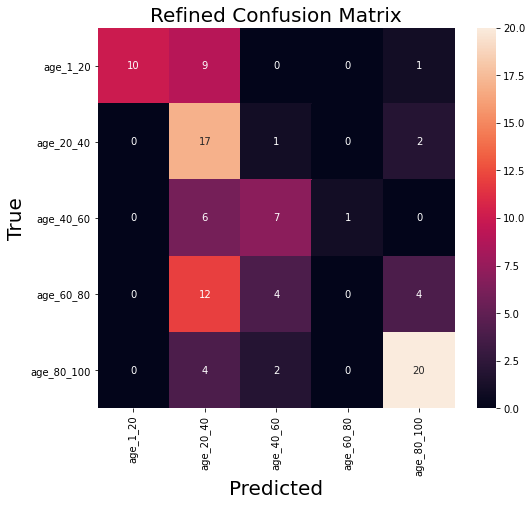

In [44]:
#Visualize kTSP baseline performance
ktsp_results = get_age(raw_ktsp_results)
true_class = get_labels(U_data)
plot_confusion_matrix(true_class, ktsp_results)

# Note:
Part 2 and part 3 are subject to high variability because of the random sampling process in filter method. The features chosen in part 2 are not always reproducible. Part 3 is subject to unstable runtime errors that do not occur every time because of the unstable selection of features in part 2. Some features will cause runtime error, but others will not. 

# Future plan: 
To counter the variability in part 2 and 3, following plan will be implemented in the futre to join the two part together:
for i in range(k):
    shuffle data
    train-test split
    calc features on train
    calc performance of kTSP on test set
    3x10 cross validate ensemble classifier on test
    for the future save everything:
          the feature set, the kTSP performance, the ensemble votes
          and the ensemble performance (R2, MAE, MED)